In [8]:
import numpy as np
import pandas as pd
from pandas import read_csv
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix, accuracy_score, recall_score, \
    ConfusionMatrixDisplay
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

## Prediction with random Forest
The Data needs to be updated, so for testing, I used a subset of the data with no missing values

In [9]:
X_train = read_csv('data/X_train.csv')
y_train = read_csv('data/y_train.csv').values.ravel()
X_test = read_csv('data/X_test.csv')
y_test = read_csv('data/y_test.csv').values.ravel()

X_train_alt = read_csv('data/X_train_alt.csv')
y_train_alt = read_csv('data/y_train_alt.csv').values.ravel()
X_test_alt = read_csv('data/X_test_alt.csv')
y_test_alt = read_csv('data/y_test_alt.csv').values.ravel()

### Random Forest Pipline

### Random Forest classification pipeline with hyperparameter optimization

This section builds a preprocessing + RandomForest pipeline, performs hyperparameter optimization with cross-validated grid search on `X_train, y_train`, and evaluates the best model on the test set.

In [55]:
categorical_features = ['ForagingGround', 'Species', 'CalendarWeek']
numeric_features = ['CCL_cm', 'CCW_cm', 'Weight_Kg']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('rf', rf_clf)
])

param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [10, 20, 30],
    'rf__min_samples_split': [2, 3],
    'rf__min_samples_leaf': [1, 2, 3],
    'rf__criterion': ['gini'],              # 'entropy'
    'rf__max_features': ['sqrt']            # 'log2'
}

rf_grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=10,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

In [56]:
rf_grid_search.fit(X_train, y_train)

rf_best_model = rf_grid_search.best_estimator_
rf_best_params = rf_grid_search.best_params_
rf_best_score = rf_grid_search.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [57]:
rf_grid_search.fit(X_train, y_train_alt)

rf_best_model_alt = rf_grid_search.best_estimator_
rf_best_params_alt = rf_grid_search.best_params_
rf_best_score_alt = rf_grid_search.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


### Evaluation of the optimized Random Forest on the **train** set

In [58]:
y_pred = rf_best_model.predict(X_train)

rf_test_accuracy = accuracy_score(y_train, y_pred)
rf_test_f1_macro = f1_score(y_train, y_pred, average='macro')
rf_test_recall_macro = recall_score(y_train, y_pred, average='macro')
rf_cm = confusion_matrix(y_train, y_pred)

rf_test_accuracy, rf_test_f1_macro, rf_test_recall_macro

(0.8315505902860312, 0.7942115059415678, 0.7076518124470933)

In [60]:
y_pred_alt = rf_best_model_alt.predict(X_train)

rf_test_accuracy_alt = accuracy_score(y_train_alt, y_pred_alt)
rf_test_f1_macro_alt = f1_score(y_train_alt, y_pred_alt, average='macro')
rf_test_recall_macro_alt = recall_score(y_train_alt, y_pred_alt, average='macro')
rf_cm_alt = confusion_matrix(y_train_alt, y_pred_alt)

rf_test_accuracy_alt, rf_test_f1_macro_alt, rf_test_recall_macro_alt

(0.8810712304888677, 0.7998308868857573, 0.7468665550253123)

### Evaluation of the optimized Random Forest on the **test** set

In [61]:
y_pred = rf_best_model.predict(X_test)

rf_test_accuracy = accuracy_score(y_test, y_pred)
rf_test_f1_macro = f1_score(y_test, y_pred, average='macro')
rf_test_recall_macro = recall_score(y_test, y_pred, average='macro')
rf_cm = confusion_matrix(y_test, y_pred)

rf_test_accuracy, rf_test_f1_macro, rf_test_recall_macro

(0.3351821039009059, 0.10887884894937998, 0.12283178229564251)

In [62]:
y_pred_alt = rf_best_model_alt.predict(X_test)

rf_test_accuracy_alt = accuracy_score(y_test_alt, y_pred_alt)
rf_test_f1_macro_alt = f1_score(y_test_alt, y_pred_alt, average='macro')
rf_test_recall_macro_alt = recall_score(y_test_alt, y_pred_alt, average='macro')
rf_cm_alt = confusion_matrix(y_test_alt, y_pred_alt)

rf_test_accuracy_alt, rf_test_f1_macro_alt, rf_test_recall_macro_alt

(0.6894065446478093, 0.4007752738490485, 0.4235351786790479)

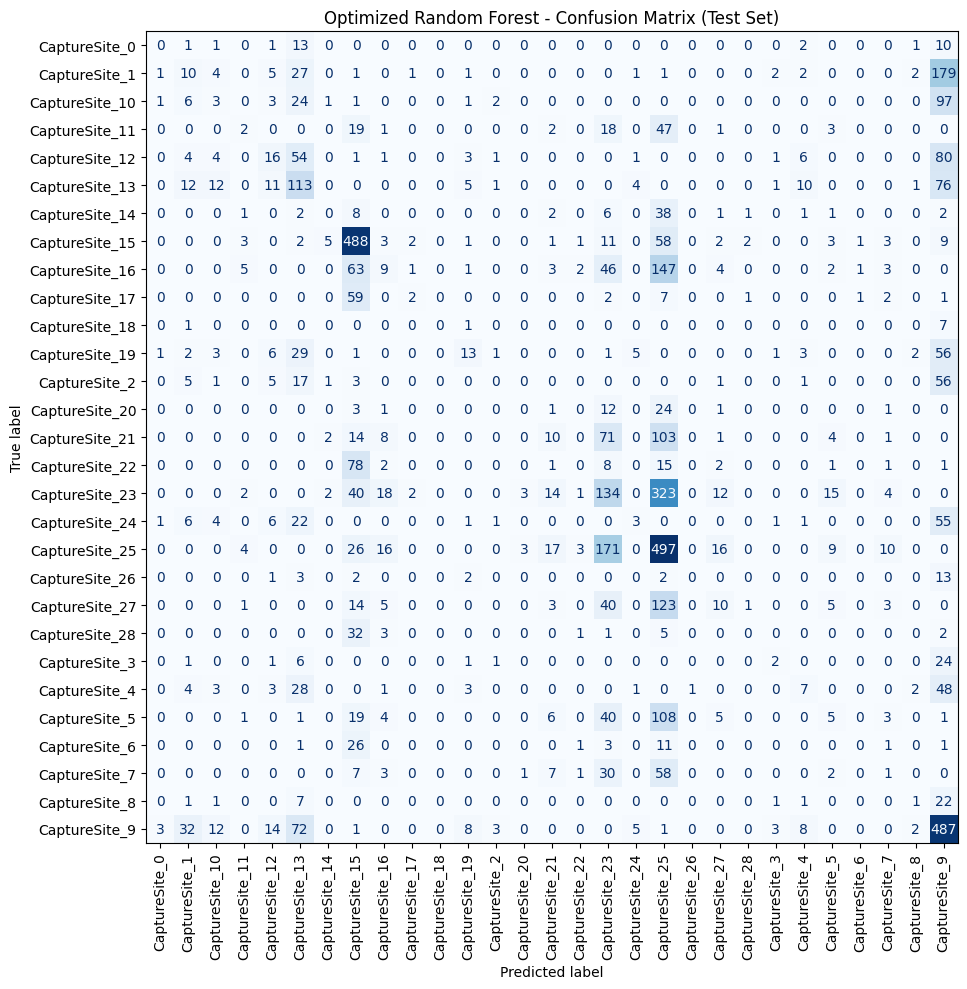

In [63]:
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf_best_model.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', colorbar=False)
plt.title('Optimized Random Forest - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

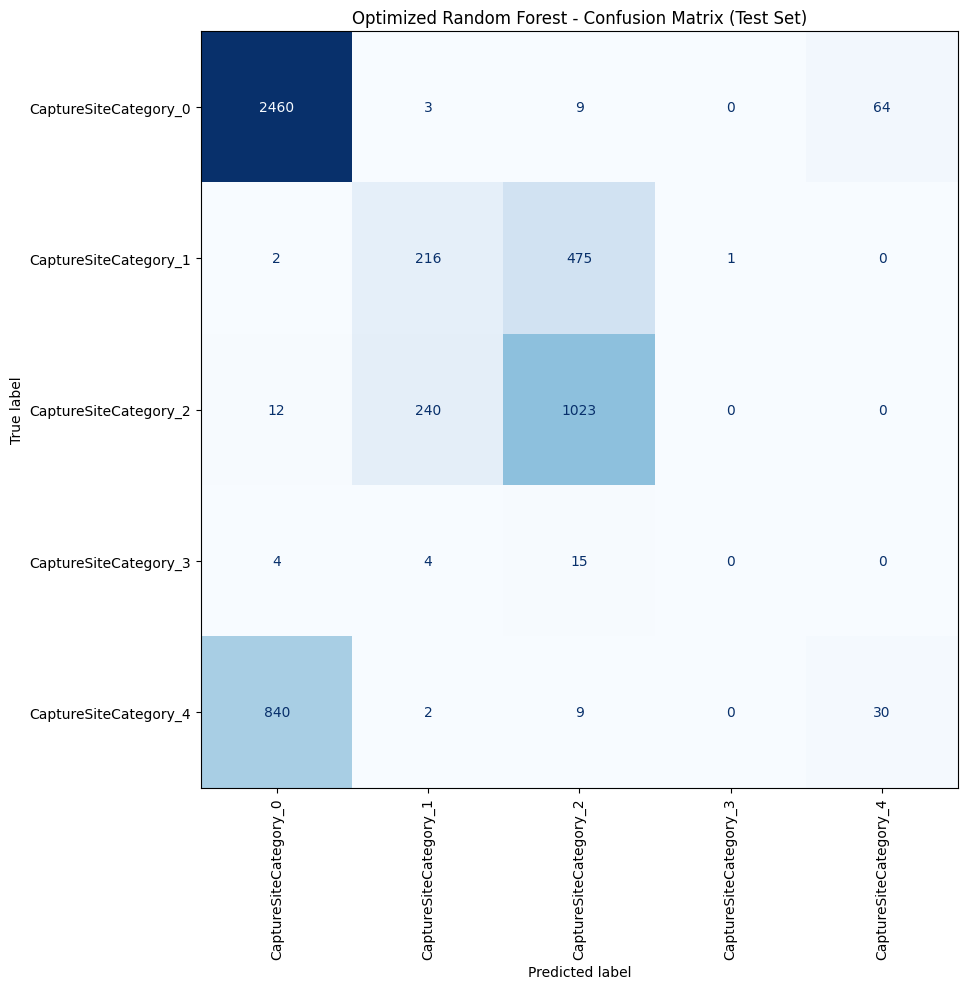

In [64]:
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm_alt, display_labels=rf_best_model_alt.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', colorbar=False)
plt.title('Optimized Random Forest - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

### Best hyperparameters and cross-validated training score

In [65]:
rf_best_params, rf_best_score


({'rf__criterion': 'gini',
  'rf__max_depth': 30,
  'rf__max_features': 'sqrt',
  'rf__min_samples_leaf': 1,
  'rf__min_samples_split': 2,
  'rf__n_estimators': 50},
 0.10795128607792737)

In [66]:
rf_best_params_alt, rf_best_score_alt

({'rf__criterion': 'gini',
  'rf__max_depth': 30,
  'rf__max_features': 'sqrt',
  'rf__min_samples_leaf': 1,
  'rf__min_samples_split': 2,
  'rf__n_estimators': 100},
 0.4119030235574299)

### Feature importance of the optimized Random Forest

The following cells extract and display the feature importances of the best Random Forest model, including the one-hot encoded categorical features.

In [67]:
preprocess_best = rf_best_model.named_steps['preprocess']
rf_best = rf_best_model.named_steps['rf']

cat_encoder = preprocess_best.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names = np.concatenate([cat_feature_names, np.array(numeric_features)])

rf_feature_importances = rf_best.feature_importances_

rf_feature_importances_df = pd.DataFrame(
    {'feature': feature_names, 'importance': rf_feature_importances}
).sort_values('importance', ascending=False)

rf_feature_importances_df

,feature,importance
65,Weight_Kg,0.20121689358482037
63,CCL_cm,0.19149965743491157
64,CCW_cm,0.19111013996415677
1,ForagingGround_Ocean,0.07859349692321872
0,ForagingGround_Creek,0.06309959194263583
...,...,...
9,Species_Species_7,0.0006711996646145915
2,Species_Species_0,0.00018176993590372583
4,Species_Species_2,8.696327409157303e-05
5,Species_Species_3,5.904080735926313e-05


In [68]:
preprocess_best_alt = rf_best_model_alt.named_steps['preprocess']
rf_best_alt = rf_best_model_alt.named_steps['rf']

cat_encoder_alt = preprocess_best_alt.named_transformers_['cat']
cat_feature_names_alt = cat_encoder_alt.get_feature_names_out(categorical_features)
feature_names_alt = np.concatenate([cat_feature_names_alt, np.array(numeric_features)])

rf_feature_importances_alt = rf_best_alt.feature_importances_

rf_feature_importances_df_alt = pd.DataFrame(
    {'feature': feature_names_alt, 'importance': rf_feature_importances_alt}
).sort_values('importance', ascending=False)

rf_feature_importances_df_alt

,feature,importance
1,ForagingGround_Ocean,0.2651787016464204
0,ForagingGround_Creek,0.23067127780034252
65,Weight_Kg,0.12019584905879087
63,CCL_cm,0.11836750482677057
64,CCW_cm,0.11412132604868586
...,...,...
9,Species_Species_7,0.0003169927161082309
2,Species_Species_0,0.0001029896105411359
4,Species_Species_2,2.0697725690932766e-05
5,Species_Species_3,4.42808404144766e-06


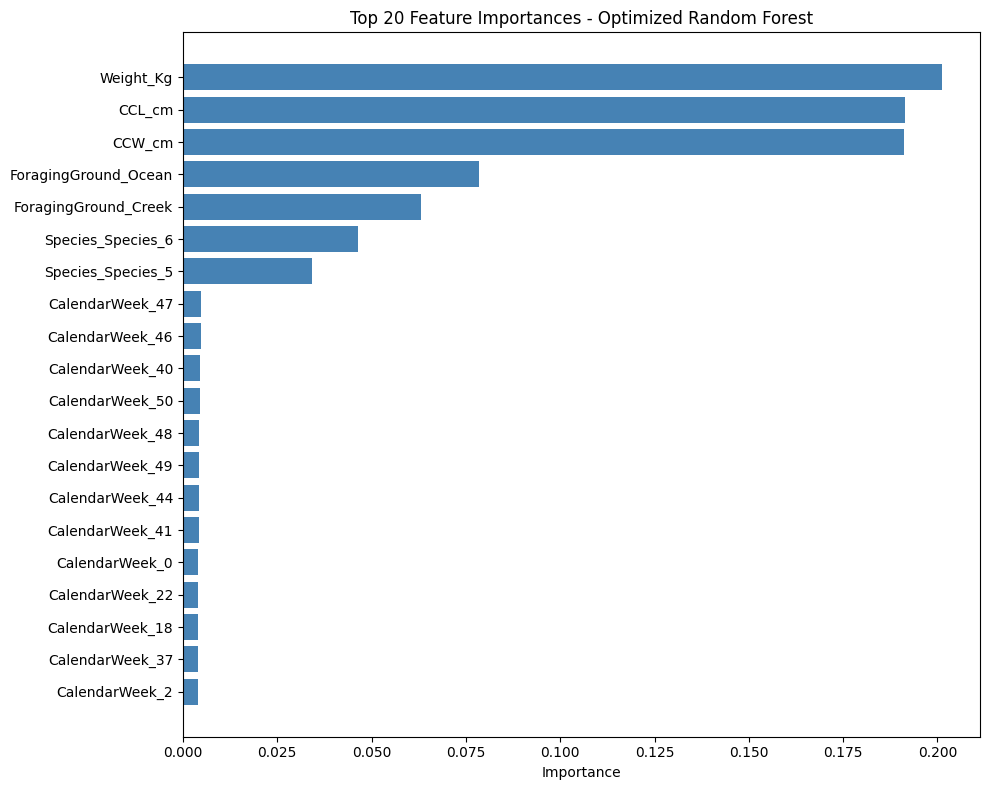

In [69]:
top_n = 20
top_features = rf_feature_importances_df.head(top_n).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'], top_features['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances - Optimized Random Forest')
plt.tight_layout()
plt.show()


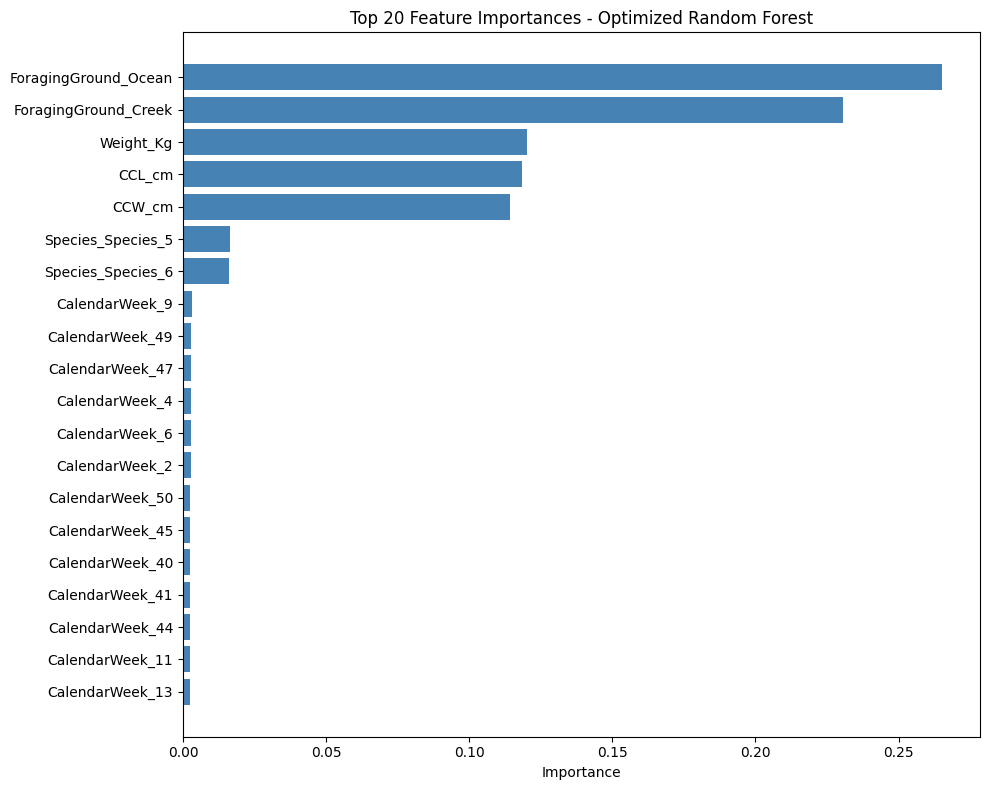

In [70]:
top_n = 20
top_features_alt = rf_feature_importances_df_alt.head(top_n).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(top_features_alt['feature'], top_features_alt['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances - Optimized Random Forest')
plt.tight_layout()
plt.show()

### Example of a single decision tree from the optimized Random Forest

The following cell visualizes one of the individual trees (here: the first tree) from the trained `rf_best` Random Forest model, limited to a small depth for readability.

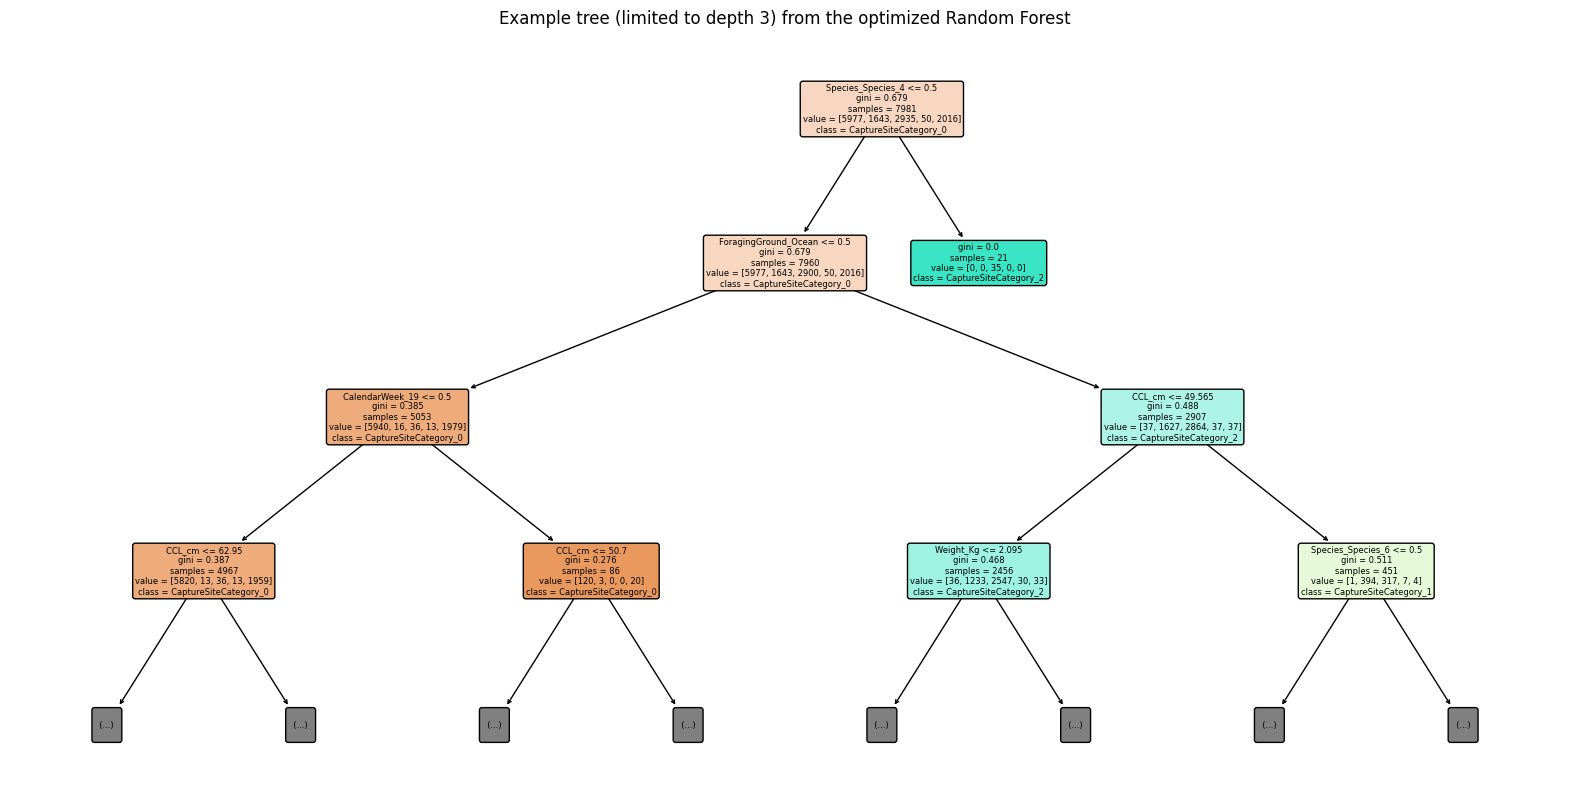

In [71]:
from sklearn.tree import plot_tree

example_tree = rf_best_alt.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(
    example_tree,
    feature_names=feature_names_alt,
    class_names=rf_best_alt.classes_,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=6
)
plt.title("Example tree (limited to depth 3) from the optimized Random Forest")
plt.show()
